# Paper Link : [Link](https://papers.nips.cc/paper/6621-label-efficient-learning-of-transferable-representations-acrosss-domains-and-tasks.pdf)
## NOTES

### Experiment  1 : Domain Adaptation across disjoint labels from MNIST and SVNH
### TODO

1. Process the MNIST and SVNH Dataset as required: Crudely Done
  * MNIST : 5-9 Classes - Done
  * SVNH : 0-4 Classes - Done
2. Creation of Architecture as shown in the image : ![architecture](https://raw.githubusercontent.com/Gokkulnath/Research-Paper-Result-Reproduction/master/Label%20Efficient%20Learning%20of%20Transferable%20Representations%20across%20Domains%20and%20Tasks/ARchitecture%20-%20Copy.PNG) - Keras Issue - Need Debugging
3. Train the Model with Optimiser Specified Separately and load the weights in the main experiment.
4. Initialise Weights only for Source CNN Model with the pretrained weights.
5. Proceed with Trainning the Entire Architecture.



# Six different methods : 
* (i) Target only: the model is trained on D2 from scratch; 
* (ii) Fine-tune: the model is pretrained on D1 and fine-tuned on D2;
* (iii) Matching networks [70]: we first pretrain the model on D3, then use D2 as the support set in the matching networks; 
* (iv) Fine-tuned matching networks: same as baseline iii, except that for each k the model is fine-tuned on D2 with 5-way (k 􀀀 1)-shot learning: k 􀀀 1 examples in each class are randomly selected as the support set, and the last example in each class is used as the query set; 
* (v) Fine-tune + adversarial: in addition to baseline ii, the model is also trained on D1 and D3 with a domain adversarial loss; 
* (vi.) Full model: fine-tune the model with the proposed multi-layer domain adversarial loss.


In [7]:
import tensorflow as tf
# Keras based Dependencies
import keras
from keras.models import Sequential,Model
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.layers import Dense,Conv2D,MaxPool2D,Dropout,BatchNormalization,Activation,Flatten,merge
from keras.initializers import TruncatedNormal
from keras.losses import categorical_crossentropy
from keras.preprocessing import image
from keras.utils import to_categorical


import numpy as np
from scipy.io import loadmat
import h5py
import os
from IPython.display import Image
from pathlib import Path

# To Grow GPU Usage dynamically when required
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

print("Keras Version : ",keras.__version__)
print("Tensorflow Version : ",tf.__version__)

Keras Version :  2.2.4
Tensorflow Version :  1.11.0


# Mnist Data Preparation :


In [3]:
(X_train,Y_train),(X_test,Y_test)=mnist.load_data()

11493376/11490434 [==============================] - 4s 0us/step


In [4]:
X_train_fil=X_train[Y_train>=5]
Y_train_fil=Y_train[Y_train>=5]

X_test_fil=X_test[Y_test>=5]
Y_test_fil=Y_test[Y_test>=5]

# One Hot Encoding
num_classes = len(np.unique(Y_train_fil))
'''
Classes : 
5 -> 1 0 0 0 0
6 -> 0 1 0 0 0
7 -> 0 0 1 0 0
8 -> 0 0 0 1 0
9 -> 0 0 0 0 1

'''
print(num_classes)
start_class= np.min(Y_train_fil)
Y_train_fil_cat= np.eye(num_classes)[Y_train_fil-start_class]
Y_test_fil_cat=np.eye(num_classes)[Y_test_fil-start_class]

5


In [5]:
print("Training Data", X_train_fil.shape,"Trainning Label",Y_train_fil_cat.shape)
print("Test Data", X_test_fil.shape,"Test Label",Y_test_fil_cat.shape)



Training Data (29404, 28, 28) Trainning Label (29404, 5)
Test Data (4861, 28, 28) Test Label (4861, 5)


# SVNH Data Preparation :

In [10]:
!mkdir Datasets
!mkdir Datasets/SVNH

In [9]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat


--2018-11-19 21:15:08--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  1.31MB/s    in 76s     

2018-11-19 21:16:24 (2.29 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2018-11-19 21:16:24--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  1.84MB/s    in 42s     

2018-11-19 21:17:07 (1.45 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [12]:
!mv *.mat Datasets/SVNH/

In [182]:
PathtoSVNH='Datasets/SVNH/'
SVNH_tr=loadmat(PathtoSVNH+'train_32x32.mat')
SVNH_tst=loadmat(PathtoSVNH+'test_32x32.mat')
SVNH_train=SVNH_tr['X']
SVNH_train_label=SVNH_tr['y']
SVNH_test=SVNH_tst['X']
SVNH_test_label=SVNH_tst['y']

# Cleaning up the data into suitable standard format
print(SVNH_train.shape)
SVNH_train=np.transpose(SVNH_train, (3,0,1,2))
SVNH_test=np.transpose(SVNH_test, (3,0,1,2))

SVNH_train_label = np.concatenate( SVNH_train_label, axis=0 )
SVNH_test_label = np.concatenate( SVNH_test_label, axis=0 )

#  '0' has label 10.
#SVNH_train_label[SVNH_train_label==10]=0
#SVNH_test_label[SVNH_test_label==10]=0

del SVNH_tr,SVNH_tst

(32, 32, 3, 73257)


In [183]:
SVNH_train_fil=SVNH_train[SVNH_train_label<5]
SVNH_train_label_fil=SVNH_train_label[SVNH_train_label<5]
SVNH_test_fil=SVNH_test[SVNH_test_label<5]
SVNH_test_label_fil=SVNH_test_label[SVNH_test_label<5]
# One Hot Encoding
'''
Classes : 
0 -> 1 0 0 0 0
1 -> 0 1 0 0 0
2 -> 0 0 1 0 0
3 -> 0 0 0 1 0
4 -> 0 0 0 0 1
'''
print(num_classes)
start_class= np.min(SVNH_train_label_fil)

num_classes = len(np.unique(SVNH_train_label_fil))
SVNH_train_label_fil_cat= np.eye(num_classes)[SVNH_train_label_fil-start_class] # -1 to make the indexing count
SVNH_test_label_fil_cat=np.eye(num_classes)[SVNH_test_label_fil-start_class]

5


In [207]:
SVNH_train.shape

(73257, 32, 32, 3)

In [208]:
import random

def plt_label(imgs,labels,target=0):
    idxs=np.where(np.argmax(labels,axis=1)==target)
    idx=random.choice(idxs)
    print(idx)
    plt.imshow(imgs[idx])
    plt.title(labels[idx])

[    2     4    12 ... 73244 73252 73253]


TypeError: Invalid dimensions for image data

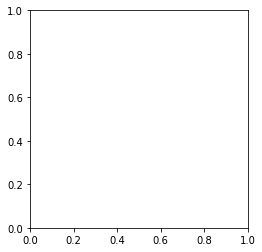

In [209]:
 plt_label(SVNH_train,to_categorical(SVNH_train_label),target=2)

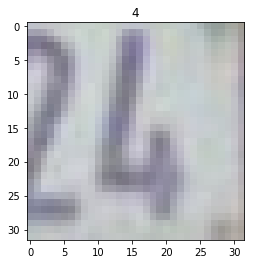

In [186]:
show_random(SVNH_train,to_categorical(SVNH_train_label),55)

In [15]:
# Resize/Center Crop the image
SVNH_train_fil=SVNH_train_fil[:,2:30,2:30,:]
SVNH_test_fil=SVNH_test_fil[:,2:30,2:30,:]


In [16]:
print("Training Data", SVNH_train_fil.shape,"Trainning Label",SVNH_train_label_fil_cat.shape)
print("Test Data", SVNH_test_fil.shape,"Test Label",SVNH_test_label_fil_cat.shape)

Training Data (45349, 28, 28, 3) Trainning Label (45349, 5)
Test Data (16397, 28, 28, 3) Test Label (16397, 5)


In [42]:
# Visualise random data from MNIST and SVNH
import matplotlib.pyplot as plt 
%matplotlib inline

def show_random(imgs,lab,idx=0,mnist=False):
    plt.imshow(imgs[idx])
    if mnist:
        plt.title(np.argmax(lab,axis=1)[idx]+5)
    else:
        plt.title(np.argmax(lab,axis=1)[idx])

    

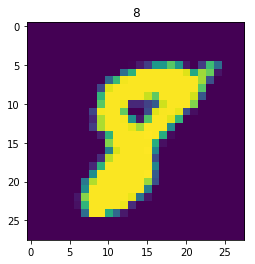

In [48]:
show_random(X_train_fil,Y_train_fil_cat,656,mnist=True)

# Use Lenet Architecture and Perform Domain Transfer Learning
# between SVNH 0-4 to MNIST 5-9



In [17]:
Image(url='https://world4jason.gitbooks.io/research-log/content/deepLearning/CNN/img/lenet.png')

In [18]:
Base_Model=Sequential()
Base_Model.add(Conv2D(batch_input_shape=(None,28,28,3),kernel_size=[5,5],filters=6))
Base_Model.add(MaxPool2D(pool_size=2, strides=2, padding='valid'))
Base_Model.add(Conv2D(kernel_size=[5,5],filters=16))
Base_Model.add(MaxPool2D(pool_size=2,strides=2,padding='valid'))
Base_Model.add(Flatten())
Base_Model.add(Dense(units=120,activation='sigmoid'))
Base_Model.add(Dense(units=84,activation='sigmoid'))
Base_Model.add(Dense(units=num_classes,activation='softmax'))


Base_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 6)         456       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
_________________________________________________________________
dense_2 (Dense)              (None, 84)                10164     
__________

In [13]:
adam=keras.optimizers.Adam(lr=0.0001, beta_1=0.75, beta_2=0.99, epsilon=None, decay=0.0)


# Tensorboard Logging - Run only if required

In [14]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)


# Model Trainning

In [15]:
Base_Model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
Base_Model.fit(SVNH_train_fil, SVNH_train_label_fil_cat,batch_size=64,epochs=10,verbose=1,validation_data=(SVNH_test_fil, SVNH_test_label_fil_cat),callbacks=[tbCallBack])

Train on 45349 samples, validate on 16397 samples
Epoch 1/10
45349/45349 [==============================] - 56s 1ms/step - loss: 1.2592 - acc: 0.5545 - val_loss: 1.1123 - val_acc: 0.6563A: 1s - l
Epoch 2/10
45349/45349 [==============================] - 52s 1ms/step - loss: 0.9406 - acc: 0.7142 - val_loss: 0.8446 - val_acc: 0.7403A: 1s - l
Epoch 3/10
45349/45349 [==============================] - 48s 1ms/step - loss: 0.6990 - acc: 0.7909 - val_loss: 0.6481 - val_acc: 0.7936
Epoch 4/10
45349/45349 [==============================] - 46s 1ms/step - loss: 0.5550 - acc: 0.8257 - val_loss: 0.5446 - val_acc: 0.8251
Epoch 5/10
45349/45349 [==============================] - 48s 1ms/step - loss: 0.4720 - acc: 0.8502 - val_loss: 0.4751 - val_acc: 0.8467
Epoch 6/10
45349/45349 [==============================] - 50s 1ms/step - loss: 0.4161 - acc: 0.8689 - val_loss: 0.4388 - val_acc: 0.8577
Epoch 7/10
45349/45349 [==============================] - 46s 1ms/step - loss: 0.3782 - acc: 0.8785 - val_loss

# Six different methods : 
* (i) Target only: the model is trained on D2 from scratch; 
* (ii) Fine-tune: the model is pretrained on D1 and fine-tuned on D2;
* (iii) Matching networks [70]: we first pretrain the model on D3, then use D2 as the support set in the matching networks; 
* (iv) Fine-tuned matching networks: same as baseline iii, except that for each k the model is fine-tuned on D2 with 5-way (k 􀀀 1)-shot learning: k 􀀀 1 examples in each class are randomly selected as the support set, and the last example in each class is used as the query set; 
* (v) Fine-tune + adversarial: in addition to baseline ii, the model is also trained on D1 and D3 with a domain adversarial loss; 
* (vi.) Full model: fine-tune the model with the proposed multi-layer domain adversarial loss.

In [18]:
# Matching networks Architecture
from keras.layers.